# Register the ground-truth CT frame to robot frame transform

In [2]:
import rtde_control
import rtde_receive
import numpy as np
import sys
import yaml
from matplotlib import pyplot as plt
import SimpleITK as sitk
import pickle as pkl


import pyrealsense2 as rs
import cv2

from force_control import z_force_control


from img_utils import flip_img

sys.path.append("../../")

from scripts.Registration3D.registration import visualize_vessel
from scripts.SurfaceContact.move import move_default_pose

from scripts.SurfaceContact.control import SurfaceContactControl
%load_ext autoreload
%autoreload 2

# Connect to robot

In [3]:
# from recording_upload_server import CaptureServer

rtde_c = rtde_control.RTDEControlInterface("192.168.1.2")
rtde_r = rtde_receive.RTDEReceiveInterface("192.168.1.2")


# Connect to ultrasound image stream

In [4]:
ultrasound_vid = cv2.VideoCapture('/dev/video8')

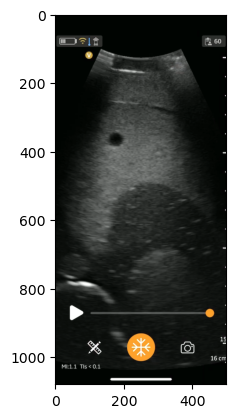

In [5]:
ret, frame = ultrasound_vid.read()		
plt.imshow(frame)

# Connect to RGB-D Camera

In [6]:
pipeline = rs.pipeline()
pipeline.start()


# Initialize surface finding controller

In [7]:
with open('../../config/pose_in_TCP_frame.yaml','r') as f:
    poses = yaml.safe_load(f)

    camera_2_tcp = poses['camera']
    probe_2_tcp = poses['probe']
    
body_color_rgb = (99, 55, 34)
body_hsv_rad = (50,50,200)
# rtde_c = rtde_r = []
sc = SurfaceContactControl(pipeline,rtde_c,rtde_r,
                           camera_2_tcp,probe_2_tcp,
                           body_color_rgb,body_hsv_rad)

In [8]:
move_default_pose(rtde_c)

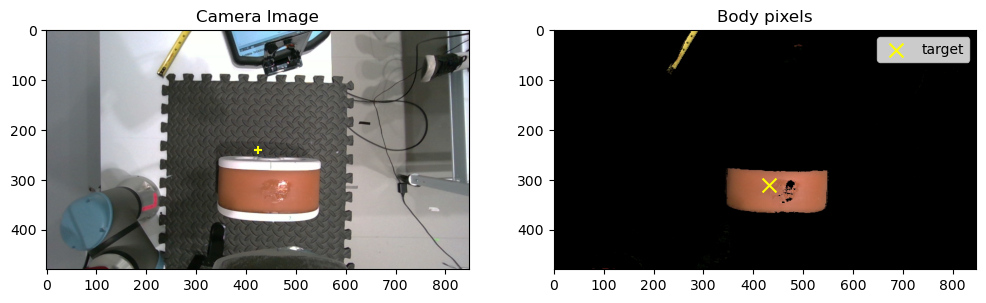

In [9]:
sc.fetchCameraStreamData()
fig = plt.figure(dpi=100,figsize = (12,4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
sc.showScene([ax1,ax2])



# Probe Control functions

In [10]:
def find_surface(sc):
    for _ in range(40):
        dist = sc.mainloop()
        dist_threshold = 0.005
        if dist<dist_threshold:
            break
    print("Arrived at above target location. Start descending.")

    sc.loc_normal_control(hover_height=0.20)
    # s = input("Find surface:?")

    if sc.getContact():
        print("Contact made.")



In [13]:
# Start the control pipeline
move_default_pose(rtde_c)

In [11]:
# Start the control pipeline
w0 = rtde_r.getActualTCPForce()# Record force zero

find_surface(sc)

Arrived at above target location. Start descending.
Contact made.


1.0 0.0


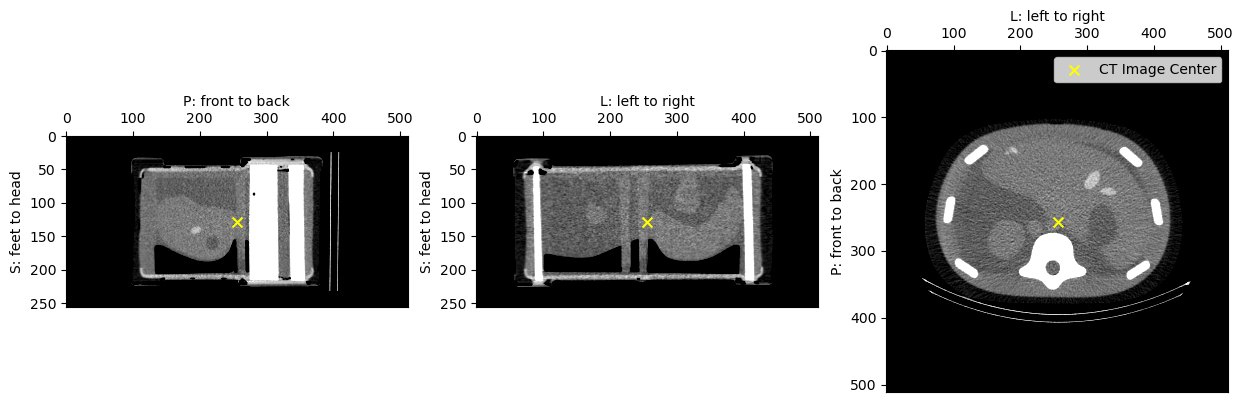

In [12]:
body_ct = sitk.ReadImage('./nifty/CT_phantom_regular.nii.gz')
body_ct = flip_img(body_ct,[True,False,False])

center_pix = np.array(body_ct.GetSize())/2
ct_center_loc = body_ct.TransformContinuousIndexToPhysicalPoint(center_pix) 

visualize_vessel(body_ct,center_pix,'CT Image Center',vmin=0.6,vmax=0.8)

## Now, manually move to robot to place the probe at the center of phantom body.

Once done, run the following code to record the ground truth parameters

In [58]:
tcp = rtde_r.getActualTCPPose()
surface_center_pose = rtde_c.poseTrans(tcp,probe_2_tcp)
with open('../../config/registration_ground_truth.yaml','w+') as fp:
    yaml.safe_dump({'surface_center_pose':surface_center_pose,'ct_center_loc':ct_center_loc},fp)

# Test the ground truth registration results

The robot's probe placement should be very accurate if using the ground truth registration

In [13]:
from ground_truth import groundTruthTargetPose, move_to_surface_center

In [21]:
move_to_surface_center(rtde_c)

In [17]:
target_force = 20
force_err_tolerance = 0.2
z_force_control(target_force,rtde_r,rtde_c,w0)

Current force is:0.4312685597862105:  Time elapsed=00:00

Current force is:19.604287114509575:  Time elapsed=00:11

Target force reached.


True

### Set and visualize a target location in CT

1.0 0.0


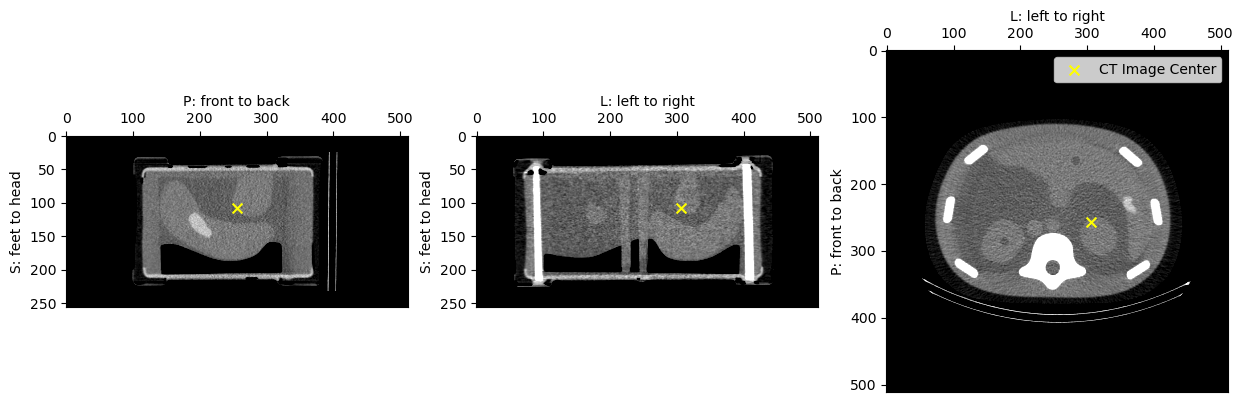

In [18]:
target_pix = center_pix+np.array([50,0,-20])
visualize_vessel(body_ct,target_pix,'CT Image Center',vmin=0.6,vmax=0.8)

### Move to the ground truth target location in physical space

In [19]:
ct_target_loc = body_ct.TransformContinuousIndexToPhysicalPoint(target_pix)

base_target_pose=groundTruthTargetPose(ct_target_loc)

tcp = rtde_r.getActualTCPPose()
base_target_pose[2]=tcp[2]
rtde_c.moveL(base_target_pose,0.01,0.1)

True

### Visualize the ultrasound image

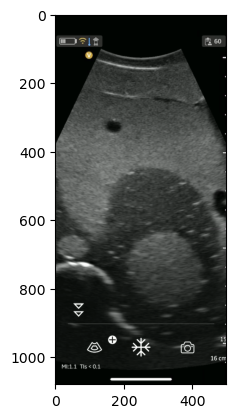

In [20]:
ret, frame = ultrasound_vid.read()		
plt.imshow(frame,cmap='gray')

# Clean up

In [22]:
# Start the control pipeline
move_default_pose(rtde_c)

In [23]:
ultrasound_vid.release()
pipeline.stop()

# Useful Scripts

In [4]:
# Script for saving default pose
with open('../../config/default_pose.yaml','w') as f:
    yaml.safe_dump({'default_pose':rtde_r.getActualTCPPose()},f)